# Data preprocessing
- Benodigde libraries importeren
- De aangemaakt CSV-bestanden inlezen
- Tijdrange overeen laten komen.

In [35]:
# Importeren benodigde libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from os import path, getcwd

In [36]:
# Dataset path
root_dir = path.join(getcwd(), 'Datasets')

# Inlezen benodigde CSV-bestanden
df_per_dag = pd.read_csv(path.join(root_dir, "data_per_dag.csv"))
df_per_leeftijd = pd.read_csv(path.join(root_dir, "data_per_leeftijd.csv"))

# Eerste week van df_per_dag halen, zodat de tijdranges in beide datasets overeen komen.
df_per_dag["Date_adj"] = pd.to_datetime(df_per_dag["Date_adj"])
df_per_dag = df_per_dag.loc[df_per_dag["Date_adj"] >= "23-03-2020"]

# Aantal IC-opnames per dag
Aan de hand van volgende features wordt bepaald hoeveel personen opgenomen zijn op de IC met een Covid-19 infectie:
- Aanwezig op verpleegafdeling verdacht of bewezen Corona	
- Opname IC Corona 
- Opname IC verdacht
- Opname IC totaal
- Opname verpleegafdeling Corona
- Opname verpleegafdeling verdacht
- Opname verpleegafdeling totaal

In [37]:
# Importeren juiste libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

C:\Users\Gebruiker\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Best parameters: {'max_depth': 13, 'max_leaf_nodes': 70, 'min_samples_leaf': 1, 'n_estimators': 45}
Regression statistics:
Mean squared error: 4986.22
Root mean squared error: 70.61
Mean absolute error: 43.94
Coefficient of determination: 0.95
Adjusted r2 : 0.94
Out-of-Back error: 0.96


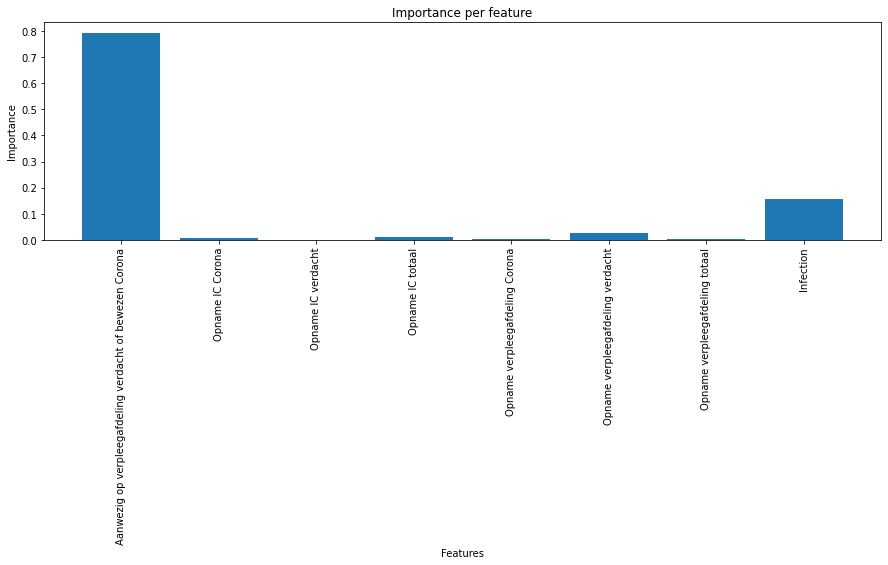

In [38]:
# Get features 
x_forest = df_per_dag.drop(["Aanwezig op IC verdacht of bewezen Corona", "Date_adj"], axis=1)
y_forest = df_per_dag["Aanwezig op IC verdacht of bewezen Corona"]

# New split
x_train_forest, x_test_forest, y_train_forest, y_test_forest = train_test_split(x_forest, y_forest, test_size=0.2, random_state=42)

# create a regressor object and set oob_score to True.
regressor = RandomForestRegressor(random_state = 42, criterion="squared_error", oob_score=True)

# Create model with a max_depth for 5 to 15 and pick the best one using 2 fold cross validation.
# The parameters max_depth, n_estimators, min_samples_leaf and max_leaf_nodes are also decided using cross validation.
parameters = { 'max_depth':range(5,15, 2), 'n_estimators':range(20,50, 5), 'max_leaf_nodes':range(20,75,5), 'min_samples_leaf':range(1,10)}
cv = GridSearchCV(regressor, parameters, n_jobs=4)
cv.fit(X=x_train_forest, y=y_train_forest)

# Display chosen parameters
print(f'Best parameters: {cv.best_params_}')
best_model = cv.best_estimator_

# Display chosen features and their scores
importance = {best_model.feature_names_in_[i]:best_model.feature_importances_[i] for i in range(0,len(best_model.feature_importances_)) if best_model.feature_importances_[i] > 0}

# Display chosen parameters
importance_list = importance.items()

x_rf, y_rf = zip(*importance_list)

plt.figure(figsize=(15,4))
plt.bar(x_rf, y_rf)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(rotation="vertical")
plt.title("Importance per feature")

# predict the test set using the best model
y_pred_tree = best_model.predict(x_test_forest)

# Calculate statistics
def show_stats(x_test, y_test, y_pred):
    n_samples = len(x_test.index)
    p_freedom = len(x_test.columns)
    r2 = r2_score(y_test, y_pred)
    adj_r2 = 1-(1-r2)*(n_samples-1)/(n_samples-p_freedom-1)
    oob = best_model.oob_score_

    print("Regression statistics:")
    print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
    print("Root mean squared error: %.2f" % np.sqrt(mean_squared_error(y_test, y_pred)))
    print("Mean absolute error: %.2f" % mean_absolute_error(y_test, y_pred))
    print("Coefficient of determination: %.2f" % r2)
    print("Adjusted r2 : %.2f" % adj_r2)
    print("Out-of-Back error: %.2f" % oob)

show_stats(x_test_forest, y_test_forest, y_pred_tree)

Uit de resultaten van de analyse scoort hoog, dit blijkt uit de score van de squarred root (R2), adjusted squarred root en de out-of-back score.  

## Aantal besmettingen per leeftijdsgroep
Gebruikmakend van de volgende features wordt bepaald hoeveel personen die geïnfecteerd zijn geraakt met Covid-19 op de IC belanden:
- Hospital_admission
- Infection
- Age_catergory

In [39]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

# Iedere leeftijd wordt toegekend aan een boolean, zodat de leeftijdsgroepen gebruikt kunnen worden bij het bewerkstelligen van het Random Forest.
# De eerste 10 regels worden getoond, zodat duidelijk is welke leeftijdsgroep welk getal krijgt.
df_per_leeftijd['Age_category']= le.fit_transform(df_per_leeftijd['Age_group'])
df_per_leeftijd.head(9)

,Date_adj,Age_group,Hospital_admission,IC_admission,Infection,Age_category
0,2020-03-23,0-19,16.0,1.0,71,0
1,2020-03-23,20-29,28.0,6.0,504,1
2,2020-03-23,30-39,90.0,10.0,551,2
3,2020-03-23,40-49,190.0,44.0,718,3
4,2020-03-23,50-59,547.0,147.0,1176,4
5,2020-03-23,60-69,730.0,246.0,971,5
6,2020-03-23,70-79,1072.0,273.0,1148,6
7,2020-03-23,80-89,564.0,23.0,1280,7
8,2020-03-23,90+,53.0,0.0,462,8


Best parameters: {'max_depth': 7, 'max_leaf_nodes': 45, 'min_samples_leaf': 1, 'n_estimators': 20}
Regression statistics:
Mean squared error: 63.44
Root mean squared error: 7.96
Mean absolute error: 3.43
Coefficient of determination: 0.91
Adjusted r2 : 0.91
Out-of-Back error: 0.95


C:\Users\Gebruiker\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


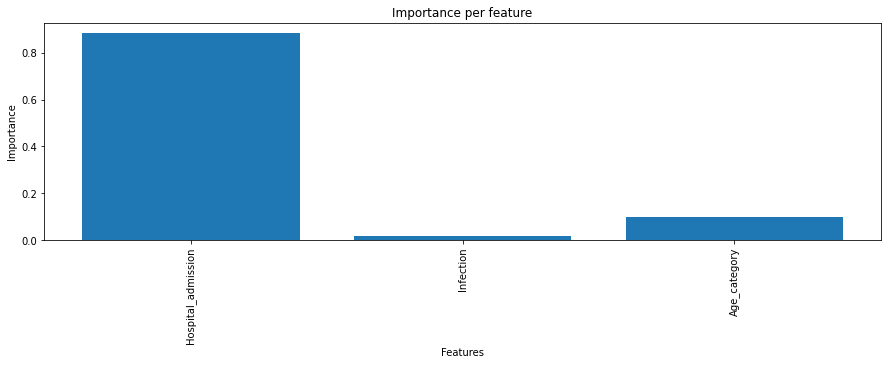

In [40]:
# Get features 
x_forest_leeftijd = df_per_leeftijd.drop(["IC_admission", "Date_adj", "Age_group"], axis=1)
y_forest_leeftijd = df_per_leeftijd["IC_admission"]

# New split
x_train_forest, x_test_forest, y_train_forest, y_test_forest = train_test_split(x_forest_leeftijd, y_forest_leeftijd, test_size=0.2, random_state=42)

# create a regressor object and set oob_score to True.
regressor = RandomForestRegressor(random_state = 42, criterion="squared_error", oob_score=True)

# Create model with a max_depth for 1 to 10.
# The parameters n_estimators, max_depth, min_samples_leaf and max_leaf_nodes are also decided using cross validation.
parameters = { 'max_depth':range(1,10), 'n_estimators':range(5,30, 5), 'max_leaf_nodes':range(5,50,5), 'min_samples_leaf':range(1,10)}
cv = GridSearchCV(regressor, parameters, n_jobs=4)
cv.fit(X=x_train_forest, y=y_train_forest)
error_score='raise'

# Display chosen parameters
print(f'Best parameters: {cv.best_params_}')
best_model = cv.best_estimator_

# Display chosen features and their scores
importance = {best_model.feature_names_in_[i]:best_model.feature_importances_[i] for i in range(0,len(best_model.feature_importances_)) if best_model.feature_importances_[i] > 0}

# Display chosen parameters
importance_list = importance.items()

x_rf, y_rf = zip(*importance_list)

plt.figure(figsize=(15,4))
plt.bar(x_rf, y_rf)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(rotation="vertical")
plt.title("Importance per feature")


# predict the test set using the best model
y_pred_tree = best_model.predict(x_test_forest)

# Calculate statistics
def show_stats(x_test, y_test, y_pred):
    n_samples = len(x_test.index)
    p_freedom = len(x_test.columns)
    r2 = r2_score(y_test, y_pred)
    adj_r2 = 1-(1-r2)*(n_samples-1)/(n_samples-p_freedom-1)
    oob = best_model.oob_score_

    print("Regression statistics:")
    print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
    print("Root mean squared error: %.2f" % np.sqrt(mean_squared_error(y_test, y_pred)))
    print("Mean absolute error: %.2f" % mean_absolute_error(y_test, y_pred))
    print("Coefficient of determination: %.2f" % r2)
    print("Adjusted r2 : %.2f" % adj_r2)
    print("Out-of-Back error: %.2f" % oob)

show_stats(x_test_forest, y_test_forest, y_pred_tree)

Net zoals het Random Forest die gemaakt is van het aantal IC-opnames per dag scoort dit random Forest zeer hoog. Echter zijn de R2, adjusted R2 score en Out-of-Back error wel lager dan bij het aantal IC-opnames per dag, de verschillen zien als volgt uit:
- Coefficient of Determination (R2) = **91%** ten opzicht van **95%**.
- Adjusted R2: **91%** ten opzichte van **94%**.
- Out-of-Back error: **96%** ten opzichte van **95%**.

Hieruit kan geconcludeerd worden dat een sterkere relatie aanwezig is tussen de dagen en het aantal IC-opnames dan de leeftijdgroep en het aantal IC-opnames, al is het verschil minimaal.